In [1]:
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig
from peft import LoraConfig
from trl import SFTConfig, SFTTrainer
from PIL import Image
import os
import io
import pandas as pd

In [2]:
# Paths to dataset
root_dir = "./Drowsiness-/-Fatigue_Detection-4"
train_dir = os.path.join(root_dir, "train")

In [3]:
# Define class mappings
label_mapping = {"0": "alert", "1": "drowsy"}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

In [4]:
# Define prompt template
prompt_template = """
You are an expert in classifying the person's state in the image into one of the following classes:
'alert' or 'drowsy'. Focus on the person's facial expressions such as mouth and eyes.
Respond with the correct class name only.
"""

In [5]:
# Function to format dataset samples into OpenAI message format
def format_data(image_path, label):
    with open(image_path, "rb") as f:
        image_data = f.read()

    return {
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": {"bytes": image_data}},
                    {"type": "text", "text": prompt_template}
                ]
            },
            {
                "role": "assistant",
                "content": [{"type": "text", "text": label}]
            }
        ]
    }

In [6]:
# Load and format dataset from CSV
def load_and_format_dataset(folder):
    samples = []
    csv_files = [f for f in os.listdir(folder) if f.endswith("_classes.csv")]
    assert len(csv_files) == 1, "Expected exactly one _classes.csv file in the folder."
    csv_path = os.path.join(folder, csv_files[0])
    df = pd.read_csv(csv_path)

    for _, row in df.iterrows():
        filename = row["filename"]
        label = "drowsy" if row["1"] == 1 else "alert"
        image_path = os.path.join(folder, filename)
        if os.path.isfile(image_path):
            sample = format_data(image_path, label)
            samples.append(sample)

    return samples

In [7]:
# Prepare formatted dataset
formatted_train_dataset = load_and_format_dataset(train_dir)

In [8]:
# Model and processor initialization
model_id = "meta-llama/Llama-3.2-11B-Vision-Instruct"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)

processor = AutoProcessor.from_pretrained(model_id)

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
# LoRA configuration
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM"
)

In [10]:
# Training configuration
training_args = SFTConfig(
    output_dir="drowsy2class_llama_finetuned",
    num_train_epochs=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    optim="adamw_torch_fused",
    logging_steps=10,
    save_strategy="epoch",
    learning_rate=2e-4,
    bf16=True,
    tf32=False,
    max_grad_norm=0.3,
    max_seq_length=1024,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    push_to_hub=False,
    report_to="tensorboard",
    gradient_checkpointing_kwargs={"use_reentrant": False},
    dataset_text_field="",
    dataset_kwargs={"skip_prepare_dataset": True}
)
training_args.remove_unused_columns = False

In [11]:
def collate_fn(examples):
    texts = [processor.apply_chat_template(example["messages"], tokenize=False) for example in examples]

    images = []
    for example in examples:
        image_data = example["messages"][0]["content"][0]["image"]["bytes"]
        try:
            image = Image.open(io.BytesIO(image_data)).convert("RGB")
            images.append(image)
        except Exception as e:
            raise ValueError(f"Error processing image bytes: {e}")

    # Nest images
    batch = processor(text=texts, images=[[img] for img in images], return_tensors="pt", padding=True)

    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    image_token_id = processor.tokenizer.convert_tokens_to_ids(processor.image_token)
    labels[labels == image_token_id] = -100
    batch["labels"] = labels

    return batch

In [12]:
# Initialize and train the model
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=formatted_train_dataset,
    data_collator=collate_fn,
    peft_config=peft_config
)

trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
10,2.862600
20,1.116100
30,0.351000
40,0.245800
50,0.211200
60,0.148100
70,0.086600
80,0.037300
90,0.031800
100,0.031000


TrainOutput(global_step=240, training_loss=0.2297259965290626, metrics={'train_runtime': 14615.3555, 'train_samples_per_second': 0.132, 'train_steps_per_second': 0.016, 'total_flos': 7550044494330804.0, 'train_loss': 0.2297259965290626})

In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig
from peft import PeftModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load model and processor
model_id = "meta-llama/Llama-3.2-11B-Vision-Instruct"
peft_model_path = "drowsy2class_llama_finetuned/checkpoint-240"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
model = PeftModel.from_pretrained(model, peft_model_path)

processor = AutoProcessor.from_pretrained(model_id)

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
# Classify a single image
def classify_image(image_path, model, processor):
    image = Image.open(image_path).convert("RGB")
    prompt = """
        Classify the person's state in the image into one of the following categories: 
        'alert' or 'drowsy'. Respond with a one-word answer only.
    """
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": prompt}
        ]}
    ]
    input_text = processor.apply_chat_template(messages, add_generation_prompt=True)

    inputs = processor(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt"
    ).to(model.device)

    outputs = model.generate(**inputs, max_new_tokens=5)
    decoded_output = processor.decode(outputs[0])
    response = decoded_output.split('<|end_header_id|>')[-1].strip().replace("<|eot_id|>", "").replace(".", "").lower()
    return response

In [4]:
# Evaluate model on test dataset
def evaluate_model_on_dataset(test_folder, model, processor):
    all_labels = []
    all_preds = []
    label_mapping = {"alert": 0, "drowsy": 1}
    inverse_label_mapping = {v: k for k, v in label_mapping.items()}

    # Locate test CSV
    csv_files = [f for f in os.listdir(test_folder) if f.endswith("_classes.csv")]
    assert len(csv_files) == 1, "Expected one _classes.csv file in the test folder."
    csv_path = os.path.join(test_folder, csv_files[0])
    df = pd.read_csv(csv_path)

    for _, row in df.iterrows():
        filename = row["filename"]
        ground_truth_label = "drowsy" if row["1"] == 1 else "alert"
        image_path = os.path.join(test_folder, filename)

        # Run model
        predicted_label = classify_image(image_path, model, processor)

        if predicted_label not in label_mapping:
            print(f"Unexpected model output '{predicted_label}' for {filename}, skipping.")
            continue

        all_labels.append(label_mapping[ground_truth_label])
        all_preds.append(label_mapping[predicted_label])

    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=["alert", "drowsy"]))

    # Confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["alert", "drowsy"], yticklabels=["alert", "drowsy"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix on Test Dataset")
    plt.tight_layout()
    plt.show()

Accuracy: 0.9689
Precision: 0.9721
Recall: 0.9689
F1 Score: 0.9698

Classification Report:
              precision    recall  f1-score   support

       alert       0.82      0.95      0.88        58
      drowsy       0.99      0.97      0.98       424

    accuracy                           0.97       482
   macro avg       0.91      0.96      0.93       482
weighted avg       0.97      0.97      0.97       482



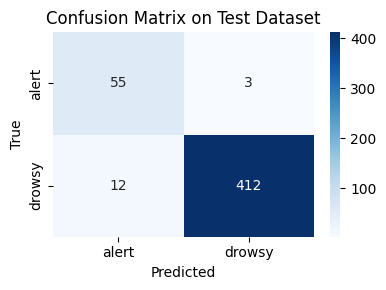

In [5]:
# Run evaluation
test_dir = "./Drowsiness-/-Fatigue_Detection-4/test"
evaluate_model_on_dataset(test_dir, model, processor)